In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Times New Roman']
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from astropy.visualization import SqrtStretch, LinearStretch, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import pandas as pd
import re
from astropy.io import fits

In [48]:
# Model Opening
model_path = 'SIE'
model_ver = 'SIE_POS'

if 'POS+FLUX' in model_ver:
    constraint = 'pos_flux'
elif 'POS' in model_ver:
    constraint = 'pos'


# Load the data
with open(model_path + '/' + model_ver + '_optresult' + '.dat', 'r') as file:
    opt_result = file.readlines()

opt_result


with open(model_path + '/' + constraint + '_point' + '.py', 'r') as file:
    py = file.readlines()

py

['#!/usr/bin/env python\n',
 'import glafic\n',
 '\n',
 "glafic.init(0.3, 0.7, -1.0, 0.7, 'SIE/SIE_POS', 20.0, 20.0, 21.56, 21.56, 0.001, 0.001, 1, verb = 0)\n",
 '\n',
 "glafic.set_secondary('chi2_splane 0', verb = 0)\n",
 "glafic.set_secondary('chi2_checknimg 0', verb = 0)\n",
 "glafic.set_secondary('chi2_restart   -1', verb = 0)\n",
 "glafic.set_secondary('chi2_usemag    1', verb = 0)\n",
 "glafic.set_secondary('hvary          0', verb = 0)\n",
 "glafic.set_secondary('ran_seed -122000', verb = 0)\n",
 '\n',
 'glafic.startup_setnum(1, 0, 1)\n',
 "glafic.set_lens(1, 'sie', 0.261343256161012, 1.58e+02, 20.80, 20.75, 0.12, -4.0, 0.0, 0.0)\n",
 'glafic.set_point(1, 1.0, 20.78, 20.78)\n',
 '\n',
 'glafic.setopt_lens(1, 0, 1, 1, 1, 1, 1, 0, 0)\n',
 'glafic.setopt_point(1, 0, 1, 1)\n',
 '\n',
 '# model_init needs to be done again whenever model parameters are changed\n',
 'glafic.model_init(verb = 0)\n',
 '\n',
 "glafic.readobs_point('/Users/ainsleylewis/Documents/Astronomy/IllustrisTNG Len

In [49]:
# Observed Positions 
obs = pd.read_fwf('obs_point/obs_point_(POS+FLUX).dat', header=None, names=['x', 'y', 'm', 'pos_err', 'm_err', 'ex1', 'ex2'], skiprows=1)
obs

plot_obs = obs[['x', 'y', 'm']]
plot_obs['x'] = (plot_obs['x'] - 20) / 0.001
plot_obs['y'] = (plot_obs['y'] - 20) / 0.001
plot_obs

/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_4868/2689651074.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_obs['x'] = (plot_obs['x'] - 20) / 0.001
/var/folders/tm/964hg0yn70x0ddsqcj4bsf8r0000gn/T/ipykernel_4868/2689651074.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_obs['y'] = (plot_obs['y'] - 20) / 0.001


,x,y,m
0,777.73,302.54,4.27
1,1273.08,956.12,6.80
2,390.91,1050.57,5.98
3,819.81,1259.31,15.30


In [50]:
# Extract the line containing 'glafic.startup_setnum('
startup_setnum_line = next(line for line in py if 'glafic.startup_setnum(' in line)

set_point_line = next(line for line in py if 'glafic.set_point(' in line)

# Extract the first number inside the parentheses
extracted_value = int(re.search(r'glafic\.startup_setnum\((\d+)', startup_setnum_line).group(1))

print(extracted_value)

set_point = int(re.search(r'glafic\.set_point\((\d+)', set_point_line).group(1))

print(set_point)

1
1


In [52]:
# Model Values 
# Find the line containing 'lens   sie' in opt_result
model_input = model_path.lower()
if model_input == 'nfw':
    model_input = 'anfw'
if model_input == 'c_sie':
    model_input = 'sie'


lens_sie_line = next(line for line in reversed(opt_result) if 'lens   ' + model_input in line)

print(lens_sie_line)

# Extract the values from the line
lens_sie_values = lens_sie_line.split()[2:]
lens_sie_values = [str(value) for value in lens_sie_values]
lens_sie_values

# Find the line containing 'glafic.set_point' in opt_result
set_point_line = next(line for line in reversed(opt_result) if 'point' in line)

print(set_point_line)

# Extract the values from the line
set_point_values = set_point_line.split()[1:]
set_point_values = [str(value) for value in set_point_values]
set_point_values


lens   sie     0.2613  1.580350e+02  2.080960e+01  2.075891e+01  1.287589e-01 -4.437098e+00  0.000000e+00  0.000000e+00 

point  1.0000  2.081270e+01  2.078004e+01 



['1.0000', '2.081270e+01', '2.078004e+01']

In [53]:
x_cent = float(set_point_values[1])
y_cent = float(set_point_values[2])
print(x_cent, y_cent)

# Predicted Positions 
pred_columns = ['x', 'y', 'mag', 'err']
pred_file = model_path + '/' + model_ver + '_point.dat'
pred = pd.read_fwf(pred_file, sep=' ', header=None, skiprows=1, names=pred_columns)
pred['x_plot'] = (pred['x'] - 20) / 0.001
pred['y_plot'] = (pred['y'] - 20) / 0.001
pred

20.8127 20.78004


,x,y,mag,err,x_plot,y_plot
0,20.7644,20.3032,-6.7047,1.049,764.4,303.2
1,21.2760,20.9607,13.6533,0.000,1276.0,960.7
2,20.3933,21.0459,15.5092,0.056,393.3,1045.9
3,20.8199,21.2593,-19.6522,0.168,819.9,1259.3


In [54]:
# FITS File 
image = model_path + '/' + model_ver + '_lens' + '.fits'

hdu_list = fits.open(image)
hdu_list.info()

Filename: SIE/SIE_POS_lens.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   (1560, 1560, 8)   float32   


In [55]:
hdu_list[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                 1560 / length of data axis 1                          
NAXIS2  =                 1560 / length of data axis 2                          
NAXIS3  =                    8 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CTYPE1  = 'LINEAR  '                                                            
CTYPE2  = 'LINEAR  '                                                            
CRPIX1  =                    1                                                  
CRPIX2  =                   

In [56]:
# Extract kappa 
kappa = hdu_list[0].data[3]
kappa = np.array(kappa)
kappa


array([[0.22178367, 0.22194855, 0.22211358, ..., 0.22730374, 0.22713377,
        0.22696394],
       [0.2219003 , 0.22206543, 0.22223075, ..., 0.22743578, 0.2272655 ,
        0.2270954 ],
       [0.22201695, 0.22218236, 0.22234793, ..., 0.22756788, 0.22739731,
        0.22722691],
       ...,
       [0.21258917, 0.21273968, 0.21289031, ..., 0.22682452, 0.22666202,
        0.22649966],
       [0.2124754 , 0.21262567, 0.21277606, ..., 0.22669277, 0.22653055,
        0.22636847],
       [0.21236168, 0.2125117 , 0.21266186, ..., 0.22656107, 0.22639914,
        0.22623736]], dtype=float32)

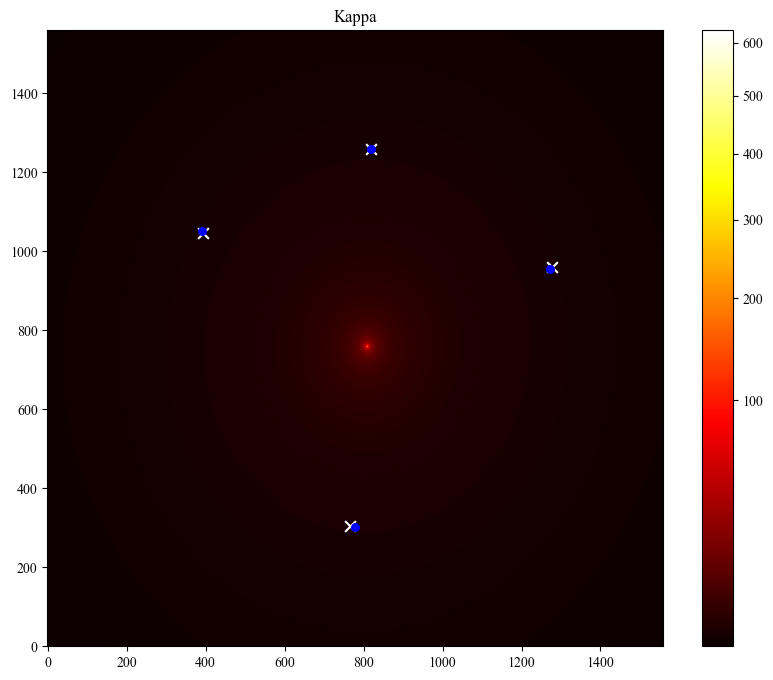

In [57]:
norm = ImageNormalize(stretch=SqrtStretch())
plt.figure(figsize=(10, 8))
plt.imshow(kappa, cmap='hot', interpolation='nearest', norm=norm)
plt.gca().invert_yaxis()
plt.colorbar()
plt.scatter(pred['x_plot'], pred['y_plot'], c='white', s=60, label='Predicted Positions', marker='x')
plt.scatter(plot_obs['x'], plot_obs['y'], c='blue', s=30, label='Observed Positions', marker='o')
plt.title('Kappa')
plt.show()

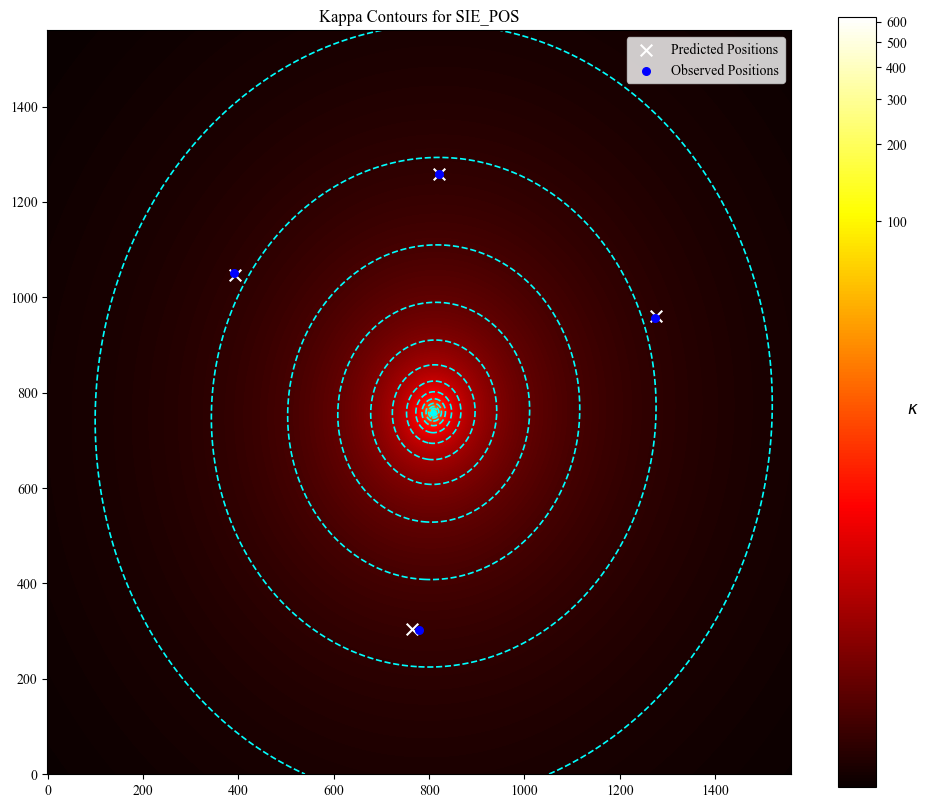

In [58]:
norm = ImageNormalize(kappa, stretch=LogStretch())
plt.figure(figsize=(12, 10))
plt.imshow(kappa, cmap='hot', norm=norm)
plt.gca().invert_yaxis()
cbar = plt.colorbar(label=r'$\kappa$')
cbar.set_label(r'$\kappa$', rotation=0, fontsize=12)

# Logarithmic levels for better distribution
levels = np.logspace(np.log10(kappa.min() + 1e-6), np.log10(kappa.max()), 20)  # Add a small offset to avoid log(0)
plt.contour(
    kappa, 
    levels=levels, 
    colors='cyan', 
    linewidths=1.2, 
    linestyles='dashed',
    alpha=1,
    extent=[0, kappa.shape[1], 0, kappa.shape[0]],
)

plt.scatter(pred['x_plot'], pred['y_plot'], c='white', s=70, label='Predicted Positions', marker='x')
plt.scatter(plot_obs['x'], plot_obs['y'], c='blue', s=30, label='Observed Positions', marker='o')
plt.title('Kappa Contours for ' + model_ver)
plt.legend()
plt.show()

Radial Kappa Value: 8.311564445495605


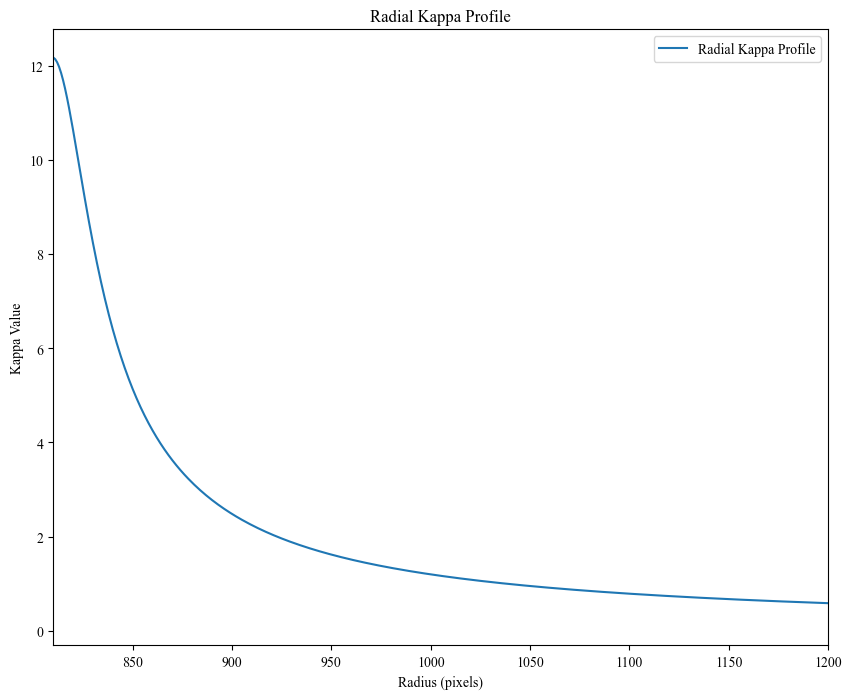

In [65]:
# Radial Kappa Plot
def radial_kappa(kappa, center, radius):
    """
    Calculate the radial kappa profile.
    
    Parameters:
        kappa (2D array): The kappa map.
        center (tuple): The center coordinates (x, y).
        radius (int): The radius for the radial profile.
        
    Returns:
        tuple: The radial distances and corresponding kappa values.
    """
    x_center, y_center = center
    y, x = np.indices(kappa.shape)
    r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
    
    # Create a mask for the radius
    mask = (r <= radius)
    
    # Calculate the mean kappa within the radius
    radial_kappa = np.mean(kappa[mask])
    
    return radial_kappa

# Example usage
center = (kappa.shape[1] // 2, kappa.shape[0] // 2)  # Center of the image
radius = 50  # Radius for the radial profile
radial_kappa_value = radial_kappa(kappa, center, radius)
print(f"Radial Kappa Value: {radial_kappa_value}")


# Plot the radial kappa profile
plt.figure(figsize=(10, 8))
plt.plot(kappa[center[1], :], label='Radial Kappa Profile')
plt.xlabel('Radius (pixels)')
plt.ylabel('Kappa Value')
plt.title('Radial Kappa Profile')
plt.xlim(810, 1200)
plt.legend()
plt.show()


Text(0, 0.5, 'Y [arcsec]')

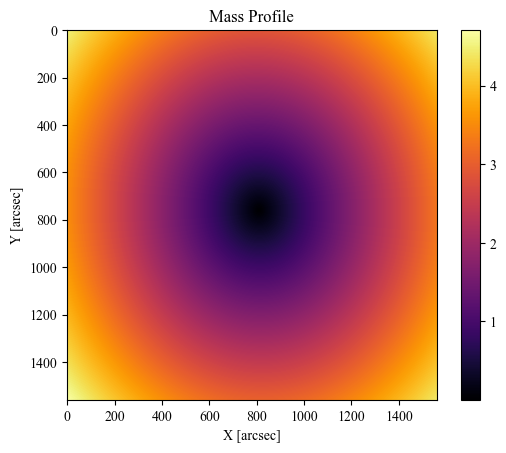

In [164]:
# Mass Profile 
plt.imshow(1/kappa, cmap='inferno')
plt.colorbar()
plt.title('Mass Profile')
plt.xlabel('X [arcsec]')
plt.ylabel('Y [arcsec]')